# Example use of the Sonic module Linckii.jl

See https://julialang.org, https://juliadb.org and https://juliastats.org for reference.

In [1]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [2]:
import Dates, JuliaDB, Random, StatsPlots

In [3]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

Get secret token,

In [4]:
include("../src/LinckiiSecrets.jl")
secret = LinckiiSecrets.keab

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

Get access token,

In [36]:
include("../src/Linckii.jl")
access = Linckii.get_access(secret)

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

`GET https://canary.noda.se/~keab/api/v1/nodes`,

In [6]:
@time site_nodes = Linckii.get_nodes(access)

 72.837504 seconds (60.90 M allocations: 3.938 GiB, 1.68% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
───────────────────────────────────
1  node_public       Bool
2  node_name         Symbol
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Int64,1}
8  node_description  String

`GET https://canary.noda.se/~keab/api/v1/devices`,

In [7]:
@time site_devices = Linckii.get_devices(access)

 38.458815 seconds (28.98 M allocations: 2.001 GiB, 1.39% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name                     device_id
──────────────────────────────────────────────────────
1            Symbol("Kelp-IQHeat")           1
2            :Scout                          2
1            Symbol("Kelp-Basic")            4
5            Symbol("Weather-Forecast")      6
6            Symbol("Grid-Basic")            7
6            Symbol("Grid-Controller")       8
7            Symbol("Heat-Load-Forecast")    9
2            :CMa1Xw                         10
2            Symbol("EcoGuard Sensor")       11
2            :WEPTech                        12
8            Symbol("Flexibility-Forecast")  13

`GET https://canary.noda.se/~keab/api/v1/sensors`,

In [8]:
@time site_sensors = Linckii.get_sensors(access)

 46.833608 seconds (37.71 M allocations: 2.596 GiB, 1.51% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

In [9]:
site = (nodes = site_nodes, devices = site_devices, sensors = site_sensors)
map(length, site)

(nodes = 279, devices = 11, sensors = 175)

Save site,

In [22]:
@time Linckii.savesite(secret; site...)

  3.292588 seconds (7.65 M allocations: 388.889 MiB, 4.18% gc time)


Load site,

In [23]:
@time site = Linckii.loadsite(secret, :nodes, :devices, :sensors)
map(length, site)

  0.135743 seconds (102.20 k allocations: 5.367 MiB)


(nodes = 279, devices = 11, sensors = 175)

Specify patterns,

In [24]:
patterns = Dict(
    4 => Dict(
        :meter_effect           => identity,
        :meter_heatenergy       => identity,
        :meter_primreturntemp   => identity,
        :meter_primsupplytemp   => identity,
        :meter_volume           => identity,
        :meter_volumeflow       => identity,
        :outdoortemp            => identity,
        :outdoortemp_offset     => identity,
    ),
    6 => Dict(
        :cloudiness             => identity,
        :outdoortemp            => identity,
        :wind_direction         => identity,
        :wind_speed             => identity,
    ),
)

Dict{Int64,Dict{Symbol,typeof(identity)}} with 2 entries:
  4 => Dict(:meter_primreturntemp=>identity,:meter_effect=>identity,:outdoortem…
  6 => Dict(:cloudiness=>identity,:outdoortemp=>identity,:wind_direction=>ident…

Get pattern nodes,

In [25]:
rs = JuliaDB.rows(Linckii.get_pattern_nodes(patterns; site...))
if true
    rs = [(node_id = 62, device_id = 4), (node_id = 93, device_id = 4)] # [rs[Random.rand(1 : end)]]
end
length(rs)

1

Save data,

In [26]:
dates = Dates.DateTime(2017, 12) : Dates.Month(1) : Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [30]:
@time for r in rs
    for sensor_name in keys(patterns[r.device_id])
        p = Linckii.urlpath(secret)
        p = Linckii.db_path(p, "data", r.node_id; db = sensor_name)
        try
            Linckii.savedata(access, r.node_id, sensor_name, dates...)
            println("$(p): Done")
        catch e
            println("$(p): $(e)")
        end
    end
end

db/linckii/~keab/data/62/meter_primreturntemp.db: Done
db/linckii/~keab/data/62/meter_effect.db: Done
db/linckii/~keab/data/62/outdoortemp.db: Done
db/linckii/~keab/data/62/meter_primsupplytemp.db: Done
db/linckii/~keab/data/62/meter_volumeflow.db: Done
db/linckii/~keab/data/62/meter_volume.db: Done
db/linckii/~keab/data/62/outdoortemp_offset.db: Done
db/linckii/~keab/data/62/meter_heatenergy.db: Done
209.726679 seconds (37.78 M allocations: 1.991 GiB, 0.46% gc time)


Random choice,

In [31]:
r = rs[Random.rand(1 : end)]

(node_id = 62, device_id = 4)

In [32]:
sensor_names = collect(keys(patterns[r.device_id]))

8-element Array{Symbol,1}:
 :meter_primreturntemp
 :meter_effect        
 :outdoortemp         
 :meter_primsupplytemp
 :meter_volumeflow    
 :meter_volume        
 :outdoortemp_offset  
 :meter_heatenergy    

In [33]:
sensor_name = sensor_names[Random.rand(1 : end)]

:meter_volume

Load data,

In [37]:
data = Linckii.loaddata(secret, r.node_id, sensor_name)

Table with 92815 rows, 3 columns:
datetime             variable       value
───────────────────────────────────────────
2017-12-01T00:12:03  :meter_volume  14117.1
2017-12-01T00:22:03  :meter_volume  14117.2
2017-12-01T00:32:02  :meter_volume  14117.3
2017-12-01T00:42:02  :meter_volume  14117.4
2017-12-01T00:52:03  :meter_volume  14117.5
2017-12-01T01:02:03  :meter_volume  14117.6
2017-12-01T01:12:03  :meter_volume  14117.7
2017-12-01T01:22:02  :meter_volume  14117.8
2017-12-01T01:32:02  :meter_volume  14117.9
2017-12-01T01:42:03  :meter_volume  14118.1
2017-12-01T01:52:03  :meter_volume  14118.2
2017-12-01T02:02:03  :meter_volume  14118.3
⋮
2019-11-30T22:12:02  :meter_volume  23193.0
2019-11-30T22:22:02  :meter_volume  23193.2
2019-11-30T22:32:03  :meter_volume  23193.3
2019-11-30T22:42:03  :meter_volume  23193.5
2019-11-30T22:52:03  :meter_volume  23193.7
2019-11-30T23:02:02  :meter_volume  23193.8
2019-11-30T23:12:02  :meter_volume  23194.0
2019-11-30T23:22:03  :meter_volume  23194.

Simple graphics,

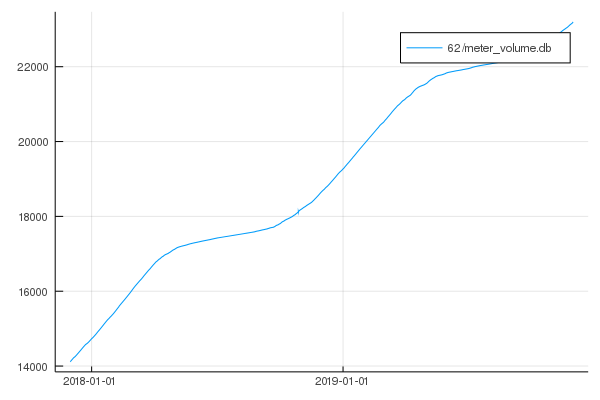

In [39]:
@df data plot(:datetime, :value, label = Linckii.db_path(r.node_id; db = sensor_name))